In the past tutorial we looked at fitting a simple ANN to a set of data and we created a model that provided a single prediction based on the input data. In many scientific applications, it is desirable to have a prediction as well as an uncertainty estimate associated with the prediction. One method of attaining uncertainty estimations in model predictions is through a Bayesian Neural Network (BNN). In this tutorial we will build multiple versions of BNNs and discuss the pros/cons of each.

# Generating Data

Let's create a function to create noisey sinusoidal data that we can work on building a probabilistic model.

In [1]:
import numpy as np

def get_noisy_data(n=300):
    np.random.seed(42)
    x = np.linspace(0, 2*np.pi, n)
    y1 = 3 * np.sin(x)
    y1 = np.concatenate((np.zeros(60), y1 + np.random.normal(0, 0.15 * np.abs(y1), n), np.zeros(60)))
    x = np.concatenate((np.linspace(-3, 0, 60), np.linspace(0, 3 * 2 * np.pi, n), np.linspace(3 * 2 * np.pi, 3 * 2 * np.pi + 3, 60)))
    y2 = 0.1 * x + 1
    y = y1 + y2
    return x.reshape([-1, 1]), y.reshape([-1, 1])

(1120, 1) (1120, 1)


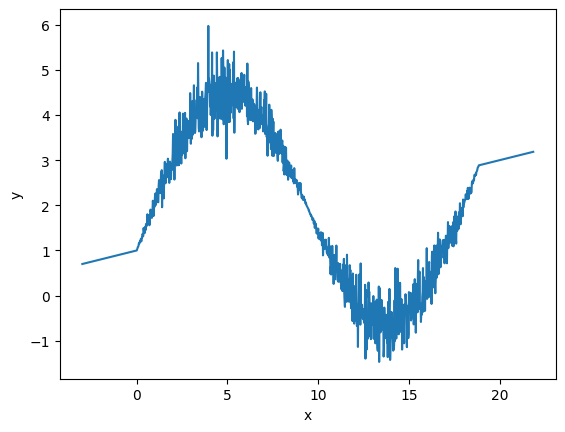

In [2]:
import matplotlib.pyplot as plt

# Create the data and visualize
x, y = get_noisy_data(n=1000)
print(x.shape, y.shape)

fig, ax = plt.subplots(1, 1)
ax.plot(x, y)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Here we see that the data has bands of increasing noise near the minimum and maximum of the sine curve that flattens out to zero noise at the edges. There is also no data present from x < -3 and x > 22. We will create a model to make predictions along with esimates of the uncertainty both within the data regions and outside of the data bounds.

# Preprocessing the data
Most ML problems optimally operate on data that is normalized. The type optimal type of normalization depends upon the structure of the data and the desired output.

For this data we will use a rather standard that shifts and scales the data to a distribution centered around 0 with standard deviation equal to 1.

$$ x' = \frac{x - \mu(x)}{\sigma(x)}$$

It is often useful to also create an inverse normalization function which can be used to convert the ML model predictions back to the physical space.

In [3]:
# Create normalization function
def normalizer(data, mean=None, std=None):
    if not mean:
        mean = np.mean(data)
    if not std:
        std = np.std(data)
    data_norm = (data - mean)/std
    return data_norm, mean, std

# Create the inverse normalization function
def inv_normalizer(data, mean, std):
    inv_data = std * data + mean
    return inv_data

# Now scale the data using the normalizers
x_norm, x_mean, x_std = normalizer(x)
y_norm, y_mean, y_std = normalizer(y)

In [4]:
from sklearn.model_selection import train_test_split

# Generate train and test datasets with 8-20 split
x_train, x_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.20, random_state=42)
# Further split the test set into a validation set (final split is 80-10-10)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# precompute the unnormalized versions of y
y_train_real = inv_normalizer(y_train, y_mean, y_std)
y_val_real = inv_normalizer(y_val, y_mean, y_std)
y_test_real = inv_normalizer(y_test, y_mean, y_std)

# Testing an Artificial Neural Network Model
First, let's test what a standard ANN will do with the above dataset to highlight the value added by a Bayesian approach.

In [5]:
pip install git+https://github.com/NREL/tf-melt.git

  Cloning https://github.com/NREL/tf-melt.git to /private/var/folders/jb/yy7lxgjd6915xnjb4_b6npk05gvryg/T/pip-req-build-78h2r2st
  Running command git clone --filter=blob:none --quiet https://github.com/NREL/tf-melt.git /private/var/folders/jb/yy7lxgjd6915xnjb4_b6npk05gvryg/T/pip-req-build-78h2r2st
  Resolved https://github.com/NREL/tf-melt.git to commit 5eacd61b8dc283015821f10bb1c2cbb09738ba59
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Import the TF-MELT architecture
from tfmelt.models import ArtificialNeuralNetwork

2024-02-07 10:59:32.084550: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
from tensorflow.keras.optimizers import Adam

# Initialize the model
model = ArtificialNeuralNetwork(
    num_feat=1,
    num_outputs=1,
    width=64,
    depth=2,
    act_fun="relu",
)
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="mse",
    run_eagerly=False,
)
model.build(input_shape=(None,1))
model.summary()

Model: "artificial_neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           multiple                  0 (unused)
                                                                 
 input_dropout (Dropout)     multiple                  0 (unused)
                                                                 
 batch_norm (BatchNormaliza  multiple                  0 (unused)
 tion)                                                           
                                                                 
 input2bulk (Dense)          multiple                  128       
                                                                 
 bulk_0 (Dense)              multiple                  4160      
                                                                 
 bulk_1 (Dense)              multiple                  4160      
                                         

In [8]:
# Now we can train the model
history = model.fit(
    x_train,
    y_train,
    validation_data = (x_val, y_val),
    epochs=100,
    batch_size=32,
)

Epoch 1/100
28/28 [==============================] - 1s 6ms/step - loss: 0.8021 - val_loss: 0.7559
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 0.6337 - val_loss: 0.5585
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 0.3415 - val_loss: 0.1745
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0836 - val_loss: 0.0427
Epoch 5/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0386
Epoch 6/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0360
Epoch 7/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0331
Epoch 8/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0359
Epoch 9/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0336
Epoch 10/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0400
Epoch 11/

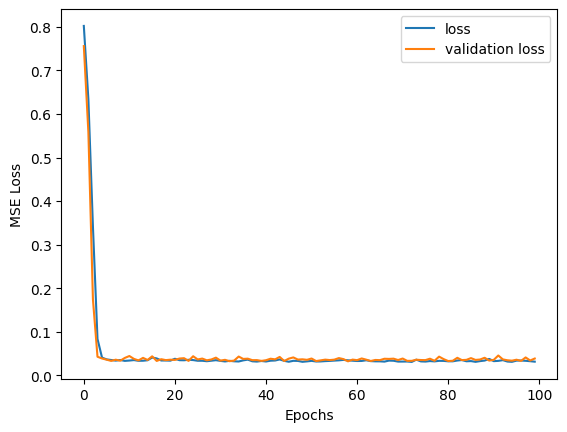

In [9]:
# Plot the loss function over time
fig, ax = plt.subplots(1, 1)
ax.plot(history.history["loss"], label="loss")
ax.plot(history.history["val_loss"], label="validation loss")
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("MSE Loss")
plt.show()

In [10]:
# Evaluate the model performance on train and validation data
pred_norm = model.predict(x_norm)
pred_norm_train = model.predict(x_train)
pred_norm_val = model.predict(x_val)
pred_norm_test = model.predict(x_test)

# Unscale the results and plot
pred_full = inv_normalizer(pred_norm, y_mean, y_std)
pred_train = inv_normalizer(pred_norm_train, y_mean, y_std)
pred_val = inv_normalizer(pred_norm_val, y_mean, y_std)
pred_test = inv_normalizer(pred_norm_test, y_mean, y_std)

# Unscale the x arrays for plotting
x_train_real = inv_normalizer(x_train, x_mean, x_std)
x_val_real = inv_normalizer(x_val, x_mean, x_std)
x_test_real = inv_normalizer(x_test, x_mean, x_std)

4/4 [==============================] - 0s 1ms/step


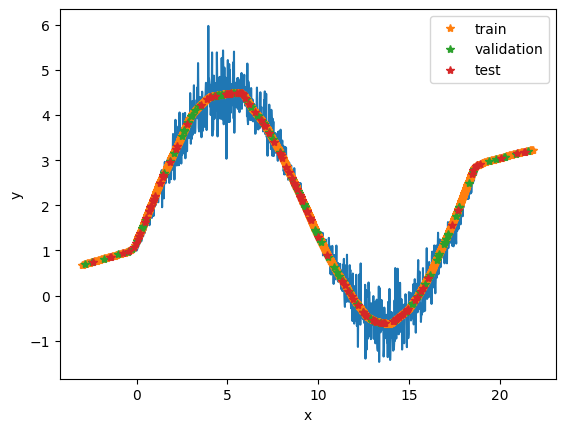

In [11]:
# Visualize the data
fig, ax = plt.subplots(1, 1)
ax.plot(x, y)
ax.plot(x_train_real, pred_train, "*", label="train")
ax.plot(x_val_real, pred_val, "*", label="validation")
ax.plot(x_test_real, pred_test, "*", label="test")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
plt.show()

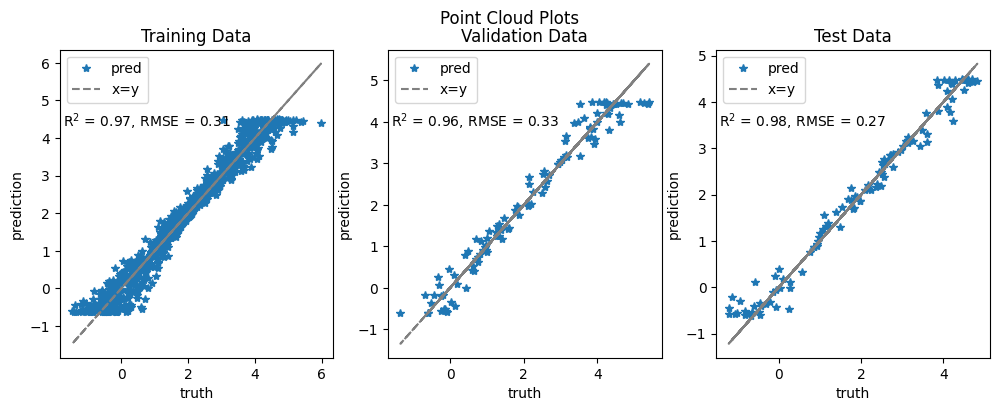

In [12]:
# Compute some statistics on the fit
from sklearn.metrics import mean_squared_error
def pred_stats(pred, truth):
    rss = np.sum((pred - truth) ** 2)
    tss = np.sum((truth - np.mean(truth)) ** 2)
    r_sq = 1 - rss / tss
    rmse = np.sqrt(mean_squared_error(truth, pred))
    return r_sq, rmse
    
# Training data
r_sq_train, rmse_train = pred_stats(pred_train, y_train_real)
r_sq_val, rmse_val = pred_stats(pred_val, y_val_real)
r_sq_test, rmse_test = pred_stats(pred_test, y_test_real)

# Visualize the predictions using a cloud plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
# Train plot
ax1.plot(y_train_real, pred_train, marker="*", linestyle="None", label="pred")
ax1.plot(y_train_real, y_train_real, linestyle="dashed", label="x=y", color="grey")
ax1.text(x=0.01, y=0.75, s=rf"R$^2$ = {r_sq_train:0.2f}, RMSE = {rmse_train:0.2f}", transform=ax1.transAxes)
ax1.legend()
ax1.set_xlabel("truth")
ax1.set_ylabel("prediction")
ax1.set_title("Training Data")
# Validation plot
ax2.plot(y_val_real, pred_val, marker="*", linestyle="None", label="pred")
ax2.plot(y_val_real, y_val_real, linestyle="dashed", label="x=y", color="grey")
ax2.text(x=0.01, y=0.75, s=rf"R$^2$ = {r_sq_val:0.2f}, RMSE = {rmse_val:0.2f}", transform=ax2.transAxes)
ax2.legend()
ax2.set_xlabel("truth")
ax2.set_ylabel("prediction")
ax2.set_title("Validation Data")
# Test plot
ax3.plot(y_test_real, pred_test, marker="*", linestyle="None", label="pred")
ax3.plot(y_test_real, y_test_real, linestyle="dashed", label="x=y", color="grey")
ax3.text(x=0.01, y=0.75, s=rf"R$^2$ = {r_sq_test:0.2f}, RMSE = {rmse_test:0.2f}", transform=ax3.transAxes)
ax3.legend()
ax3.set_xlabel("truth")
ax3.set_ylabel("prediction")
ax3.set_title("Test Data")

fig.suptitle('Point Cloud Plots')
plt.show()

For both of these plots we see that the model is able to pick up the mean of the data, but is not able to represent the uncertainty in the data either due to the model or data errors.

Because of this, we see that the point cloud plots have similar statistics across the training, validation, and test data sets which is largely due to the data uncertainties and not representative of the overall model fit.

# Moving to a Bayesian Neural Network
Now, let's build a BNN that learns the full probability distribution at each of the neuron instead of a single value.

In [13]:
# Import the Bayesian specific tensorflow layers
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# Define the divergence functions for the kernels and biases
num_points = x_train.shape[0]
kernel_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, p) / num_points
bias_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, p) / num_points

# Define the loss function
def neg_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

# Define the BNN
width = 64
inputs = Input(shape=(1,))
# DenseFlipout layer is an individual bayesian layer for VI
x = tfp.layers.DenseFlipout(
    width,
    bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
    bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
    kernel_divergence_fn=kernel_divergence_fn,
    bias_divergence_fn=bias_divergence_fn,
    activation="relu",
)(inputs)
x = tfp.layers.DenseFlipout(
    width,
    bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
    bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
    kernel_divergence_fn=kernel_divergence_fn,
    bias_divergence_fn=bias_divergence_fn,
    activation="relu",
)(x)
x = tfp.layers.DenseFlipout(
    width,
    bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
    bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
    kernel_divergence_fn=kernel_divergence_fn,
    bias_divergence_fn=bias_divergence_fn,
    activation="relu",
)(x)
# Final layer with 2 neurons to connect to outputs
x = tfp.layers.DenseFlipout(
    2,
    bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
    bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
    kernel_divergence_fn=kernel_divergence_fn,
    bias_divergence_fn=bias_divergence_fn,
)(x)
# Output layer
outputs = tfp.layers.DistributionLambda(
    lambda t: tfp.distributions.Normal(loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:]))
)(x)

# Compile model
model = Model(inputs=inputs, outputs=outputs)
model.compile(Adam(learning_rate=1e-3), loss=neg_log_likelihood)
model.summary()


/Users/nwimer/miniconda3/envs/nrel-ai/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/nwimer/miniconda3/envs/nrel-ai/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_flipout (DenseFlipou  (None, 64)                256       
 t)                                                              
                                                                 
 dense_flipout_1 (DenseFlip  (None, 64)                8320      
 out)                                                            
                                                                 
 dense_flipout_2 (DenseFlip  (None, 64)                8320      
 out)                                                            
                                                                 
 dense_flipout_3 (DenseFlip  (None, 2)                 260       
 out)                                                        

In [14]:
# Now we can train the BNN as normal
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
)

Epoch 1/100
28/28 [==============================] - 3s 23ms/step - loss: 25.6368 - val_loss: 25.5295
Epoch 2/100
28/28 [==============================] - 0s 3ms/step - loss: 25.2433 - val_loss: 25.0811
Epoch 3/100
28/28 [==============================] - 0s 3ms/step - loss: 24.8719 - val_loss: 24.7183
Epoch 4/100
28/28 [==============================] - 0s 3ms/step - loss: 24.5295 - val_loss: 24.3537
Epoch 5/100
28/28 [==============================] - 0s 3ms/step - loss: 24.1409 - val_loss: 23.9362
Epoch 6/100
28/28 [==============================] - 0s 3ms/step - loss: 23.7398 - val_loss: 23.4986
Epoch 7/100
28/28 [==============================] - 0s 3ms/step - loss: 23.3835 - val_loss: 23.2212
Epoch 8/100
28/28 [==============================] - 0s 3ms/step - loss: 23.1051 - val_loss: 22.9211
Epoch 9/100
28/28 [==============================] - 0s 3ms/step - loss: 22.8138 - val_loss: 22.6835
Epoch 10/100
28/28 [==============================] - 0s 3ms/step - loss: 22.5799 - val_lo

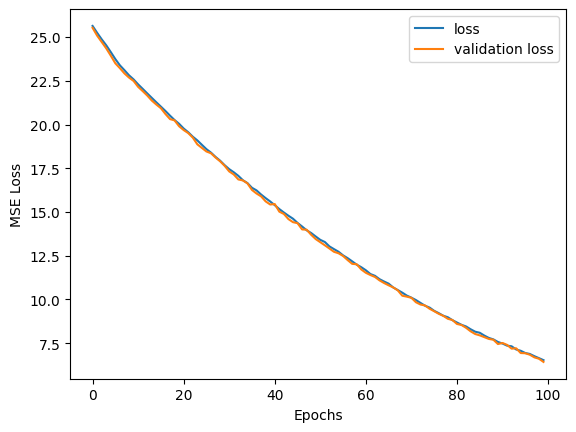

In [15]:
# Plot the loss function over time
fig, ax = plt.subplots(1, 1)
ax.plot(history.history["loss"], label="loss")
ax.plot(history.history["val_loss"], label="validation loss")
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("MSE Loss")
plt.show()

In [16]:
# Analyze the results
x_pred_real = np.arange(-10, 30, 0.3)
x_pred, _, _ = normalizer(x_pred_real, mean=x_mean, std=x_std)

yhat = model(x_train)
assert isinstance(yhat, tfp.distributions.Distribution)

ymean = np.squeeze(yhat.mean().numpy())
ystd = np.squeeze(yhat.stddev().numpy())

ymean = inv_normalizer(ymean, y_mean, y_std)
ystd = inv_normalizer(ystd, y_mean, y_std)

runs = 100

vi_cpd = np.zeros((runs, len(x_pred)))
for i in range(runs):
    pred_tmp = model.predict(x_pred)
    pred_tmp = inv_normalizer(pred_tmp, y_mean, y_std)
    vi_cpd[i, :] = np.reshape(pred_tmp, len(x_pred))

5/5 [==============================] - 0s 2ms/step


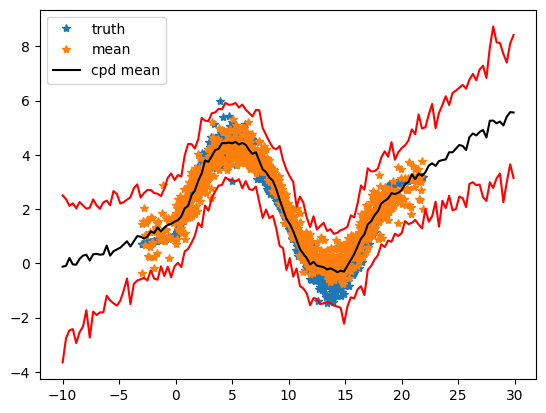

In [17]:
x_train_real = inv_normalizer(x_train, x_mean, x_std)
y_train_real = inv_normalizer(y_train, y_mean, y_std)

ystd_p = inv_normalizer(yhat.mean() + 2*yhat.stddev(), y_mean, y_std)
ystd_m = inv_normalizer(yhat.mean() - 2*yhat.stddev(), y_mean, y_std)

fig, ax = plt.subplots(1, 1)
ax.plot(x_train_real, y_train_real, marker="*", linestyle="None", label="truth")
ax.plot(x_train_real, ymean, marker="*", linestyle="None", label="mean")
# # ax.plot(x, ymean + 2* ystd, label="")
# ax.fill_between(
#     np.squeeze(x_train_real),
#     np.squeeze(ystd_p),
#     np.squeeze(ystd_m),
#     label="2 std",
#     alpha=0.3,
#     color="yellow",
# )
ax.plot(x_pred_real, np.mean(vi_cpd, axis=0), color="black", label="cpd mean")
ax.plot(x_pred_real, np.quantile(vi_cpd, 0.025, axis=0), color="red")
ax.plot(x_pred_real, np.quantile(vi_cpd, 0.975, axis=0), color="red")
ax.legend()
plt.show()

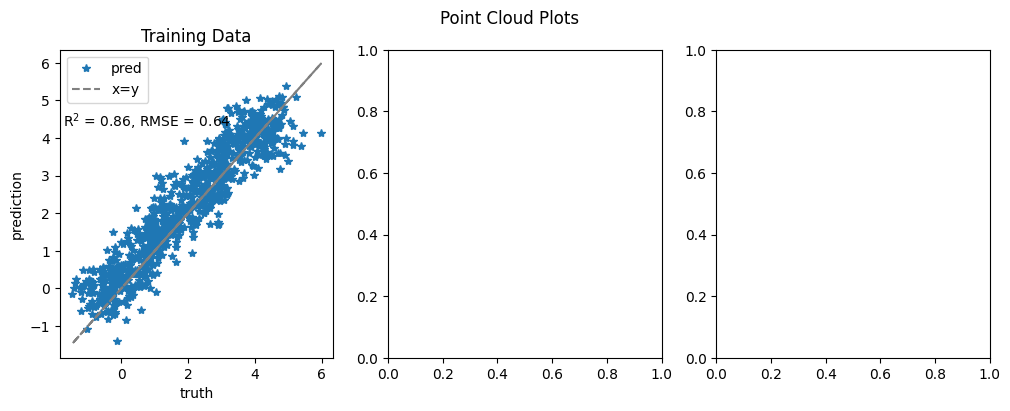

In [18]:
yhat_train = model(x_train)
assert isinstance(yhat_train, tfp.distributions.Distribution)

ymean_train = np.squeeze(yhat_train.mean().numpy())
ystd_train = np.squeeze(yhat_train.stddev().numpy())

ymean_train = inv_normalizer(ymean_train, y_mean, y_std).reshape([-1, 1])
ystd_train = inv_normalizer(ystd_train, y_mean, y_std)

# # Training data
r_sq_train, rmse_train = pred_stats(ymean_train, y_train_real)
# r_sq_val, rmse_val = pred_stats(pred_val, y_val_real)
# r_sq_test, rmse_test = pred_stats(pred_test, y_test_real)

# Visualize the predictions using a cloud plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
# Train plot
ax1.plot(y_train_real, ymean_train, marker="*", linestyle="None", label="pred")
ax1.plot(y_train_real, y_train_real, linestyle="dashed", label="x=y", color="grey")
ax1.text(x=0.01, y=0.75, s=rf"R$^2$ = {r_sq_train:0.2f}, RMSE = {rmse_train:0.2f}", transform=ax1.transAxes)
ax1.legend()
ax1.set_xlabel("truth")
ax1.set_ylabel("prediction")
ax1.set_title("Training Data")
# # Validation plot
# ax2.plot(y_val_real, pred_val, marker="*", linestyle="None", label="pred")
# ax2.plot(y_val_real, y_val_real, linestyle="dashed", label="x=y", color="grey")
# ax2.text(x=0.01, y=0.75, s=rf"R$^2$ = {r_sq_val:0.2f}, RMSE = {rmse_val:0.2f}", transform=ax2.transAxes)
# ax2.legend()
# ax2.set_xlabel("truth")
# ax2.set_ylabel("prediction")
# ax2.set_title("Validation Data")
# # Test plot
# ax3.plot(y_test_real, pred_test, marker="*", linestyle="None", label="pred")
# ax3.plot(y_test_real, y_test_real, linestyle="dashed", label="x=y", color="grey")
# ax3.text(x=0.01, y=0.75, s=rf"R$^2$ = {r_sq_test:0.2f}, RMSE = {rmse_test:0.2f}", transform=ax3.transAxes)
# ax3.legend()
# ax3.set_xlabel("truth")
# ax3.set_ylabel("prediction")
# ax3.set_title("Test Data")

fig.suptitle('Point Cloud Plots')
plt.show()

# Testing a Bayesian Last Layer instead of a full Bayesian NN

In [19]:
# Define the divergence functions for the kernels and biases'
from tensorflow.keras.layers import Dense

num_points = x_train.shape[0]
kernel_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, p) / num_points
bias_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, p) / num_points

# Define the loss function
def neg_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

# Define the BNN
width = 64
inputs = Input(shape=(1,))
x = Dense(width, activation="relu")(inputs)
x = Dense(width, activation="relu")(x)
x = Dense(width, activation="relu")(x)
# Final layer with 2 neurons to connect to outputs
x = tfp.layers.DenseFlipout(
    2,
    bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
    bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
    kernel_divergence_fn=kernel_divergence_fn,
    bias_divergence_fn=bias_divergence_fn,
)(x)
# Output layer
outputs = tfp.layers.DistributionLambda(
    lambda t: tfp.distributions.Normal(loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:]))
)(x)

# Compile model
model = Model(inputs=inputs, outputs=outputs)
model.compile(Adam(learning_rate=1e-3), loss=neg_log_likelihood)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_flipout_4 (DenseFlip  (None, 2)                 260       
 out)                                                            
                                                                 
 distribution_lambda_1 (Dis  ((None, 1),               0         
 tributionLambda)             (None, 1))                   

/Users/nwimer/miniconda3/envs/nrel-ai/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/nwimer/miniconda3/envs/nrel-ai/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [20]:
# Now we can train the BNN as normal
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
)

Epoch 1/100
28/28 [==============================] - 2s 13ms/step - loss: 1.8381 - val_loss: 1.8036
Epoch 2/100
28/28 [==============================] - 0s 3ms/step - loss: 1.6741 - val_loss: 1.6540
Epoch 3/100
28/28 [==============================] - 0s 3ms/step - loss: 1.5450 - val_loss: 1.5027
Epoch 4/100
28/28 [==============================] - 0s 3ms/step - loss: 1.3556 - val_loss: 1.2509
Epoch 5/100
28/28 [==============================] - 0s 3ms/step - loss: 1.1054 - val_loss: 1.0072
Epoch 6/100
28/28 [==============================] - 0s 3ms/step - loss: 0.9739 - val_loss: 0.9481
Epoch 7/100
28/28 [==============================] - 0s 2ms/step - loss: 0.9407 - val_loss: 0.9330
Epoch 8/100
28/28 [==============================] - 0s 2ms/step - loss: 0.9172 - val_loss: 0.9336
Epoch 9/100
28/28 [==============================] - 0s 2ms/step - loss: 0.9001 - val_loss: 0.8796
Epoch 10/100
28/28 [==============================] - 0s 3ms/step - loss: 0.8805 - val_loss: 0.8577
Epoch 11

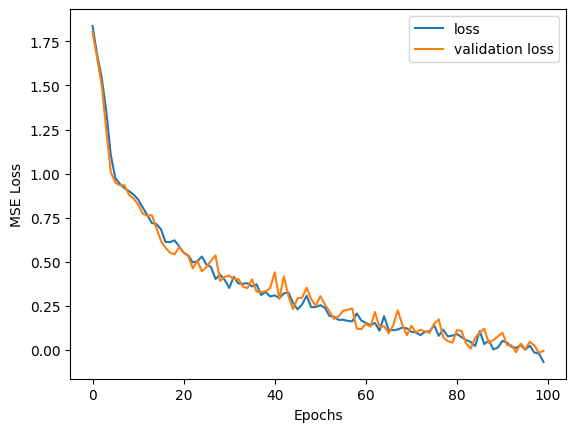

In [21]:
# Plot the loss function over time
fig, ax = plt.subplots(1, 1)
ax.plot(history.history["loss"], label="loss")
ax.plot(history.history["val_loss"], label="validation loss")
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("MSE Loss")
plt.show()

In [22]:
# Analyze the results
x_pred_real = np.arange(-10, 30, 0.3)
x_pred, _, _ = normalizer(x_pred_real, mean=x_mean, std=x_std)

yhat = model(x_train, training=False)
assert isinstance(yhat, tfp.distributions.Distribution)

ymean = np.squeeze(yhat.mean().numpy())
ystd = np.squeeze(yhat.stddev().numpy())

ymean = inv_normalizer(ymean, y_mean, y_std)
ystd = inv_normalizer(ystd, y_mean, y_std)

runs = 100

vi_cpd = np.zeros((runs, len(x_pred)))
for i in range(runs):
    pred_tmp = model.predict(x_pred)
    pred_tmp = inv_normalizer(pred_tmp, y_mean, y_std)
    vi_cpd[i, :] = np.reshape(pred_tmp, len(x_pred))

5/5 [==============================] - 0s 1ms/step


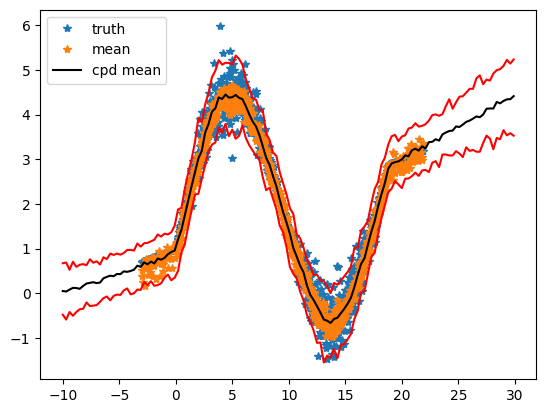

In [23]:
x_train_real = inv_normalizer(x_train, x_mean, x_std)
y_train_real = inv_normalizer(y_train, y_mean, y_std)

ystd_p = inv_normalizer(yhat.mean() + 2*yhat.stddev(), y_mean, y_std)
ystd_m = inv_normalizer(yhat.mean() - 2*yhat.stddev(), y_mean, y_std)

fig, ax = plt.subplots(1, 1)
ax.plot(x_train_real, y_train_real, marker="*", linestyle="None", label="truth")
ax.plot(x_train_real, ymean, marker="*", linestyle="None", label="mean")
# # ax.plot(x, ymean + 2* ystd, label="")
# ax.fill_between(
#     np.squeeze(x_train_real),
#     np.squeeze(ystd_p),
#     np.squeeze(ystd_m),
#     label="2 std",
#     alpha=0.3,
#     color="yellow",
# )
ax.plot(x_pred_real, np.mean(vi_cpd, axis=0), color="black", label="cpd mean")
ax.plot(x_pred_real, np.quantile(vi_cpd, 0.025, axis=0), color="red")
ax.plot(x_pred_real, np.quantile(vi_cpd, 0.975, axis=0), color="red")
ax.legend()
plt.show()

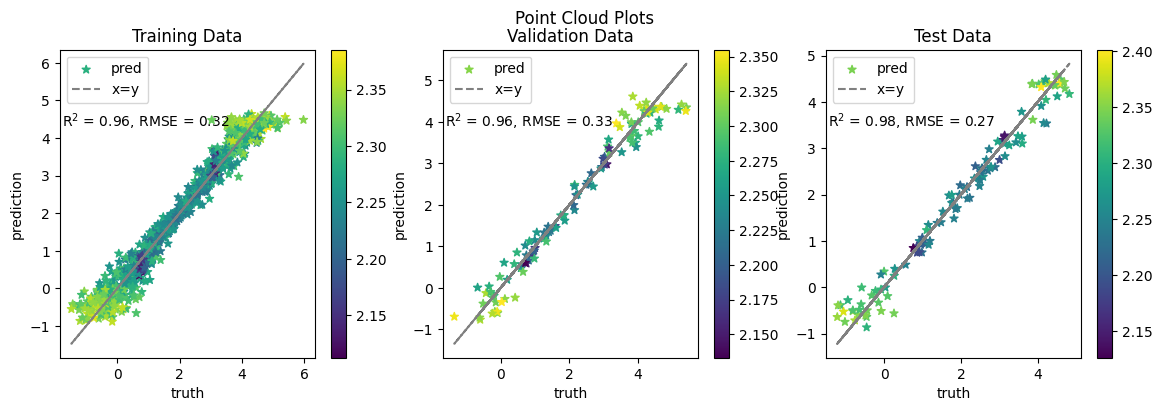

In [24]:
# Analyze the results
# x_pred_real = np.arange(-10, 30, 0.3)
# x_pred, _, _ = normalizer(x_pred_real, mean=x_mean, std=x_std)

yhat_train = model(x_train, training=False)
yhat_val = model(x_val, training=False)
yhat_test = model(x_test, training=False)
assert isinstance(yhat_train, tfp.distributions.Distribution)
assert isinstance(yhat_val, tfp.distributions.Distribution)
assert isinstance(yhat_test, tfp.distributions.Distribution)

ymean_train = np.squeeze(yhat_train.mean().numpy())
ystd_train = np.squeeze(yhat_train.stddev().numpy())
ymean_val = np.squeeze(yhat_val.mean().numpy())
ystd_val = np.squeeze(yhat_val.stddev().numpy())
ymean_test = np.squeeze(yhat_test.mean().numpy())
ystd_test = np.squeeze(yhat_test.stddev().numpy())

ymean_train = inv_normalizer(ymean_train, y_mean, y_std).reshape([-1, 1])
ystd_train = inv_normalizer(ystd_train, y_mean, y_std)
ymean_val = inv_normalizer(ymean_val, y_mean, y_std).reshape([-1, 1])
ystd_val = inv_normalizer(ystd_val, y_mean, y_std)
ymean_test = inv_normalizer(ymean_test, y_mean, y_std).reshape([-1, 1])
ystd_test = inv_normalizer(ystd_test, y_mean, y_std)

# # Training data
r_sq_train, rmse_train = pred_stats(ymean_train, y_train_real)
r_sq_val, rmse_val = pred_stats(pred_val, y_val_real)
r_sq_test, rmse_test = pred_stats(pred_test, y_test_real)

# Visualize the predictions using a cloud plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
# Train plot
p1 = ax1.scatter(y_train_real, ymean_train, marker="*", linestyle="None", label="pred", c=ystd_train)
ax1.plot(y_train_real, y_train_real, linestyle="dashed", label="x=y", color="grey")
ax1.text(x=0.01, y=0.75, s=rf"R$^2$ = {r_sq_train:0.2f}, RMSE = {rmse_train:0.2f}", transform=ax1.transAxes)
ax1.legend()
ax1.set_xlabel("truth")
ax1.set_ylabel("prediction")
ax1.set_title("Training Data")
fig.colorbar(p1, ax=ax1)
# Validation plot
p2 = ax2.scatter(y_val_real, ymean_val, marker="*", linestyle="None", label="pred", c=ystd_val)
ax2.plot(y_val_real, y_val_real, linestyle="dashed", label="x=y", color="grey")
ax2.text(x=0.01, y=0.75, s=rf"R$^2$ = {r_sq_val:0.2f}, RMSE = {rmse_val:0.2f}", transform=ax2.transAxes)
ax2.legend()
ax2.set_xlabel("truth")
ax2.set_ylabel("prediction")
ax2.set_title("Validation Data")
fig.colorbar(p2, ax=ax2)
# Test plot
p3 = ax3.scatter(y_test_real, ymean_test, marker="*", linestyle="None", label="pred", c=ystd_test)
ax3.plot(y_test_real, y_test_real, linestyle="dashed", label="x=y", color="grey")
ax3.text(x=0.01, y=0.75, s=rf"R$^2$ = {r_sq_test:0.2f}, RMSE = {rmse_test:0.2f}", transform=ax3.transAxes)
ax3.legend()
ax3.set_xlabel("truth")
ax3.set_ylabel("prediction")
ax3.set_title("Test Data")
fig.colorbar(p3, ax=ax3)

fig.suptitle('Point Cloud Plots')
plt.show()